In [1]:
import os

import ray
import yaml
from ray.rllib.agents.ppo import PPOTrainer

import foundation
from foundation.utils import plotting
from foundation.utils.rllib_env_wrapper import RLlibEnvWrapper


def generate_rollout_from_current_trainer_policy(trainer, env_obj, num_dense_logs=1):
    dense_logs = {}

    for idx in range(num_dense_logs):
        planner_action = []
        profitability = []
        equality = []
        period_step = []

        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()

        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            period_step.append(env_obj.env._steps_in_period)
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)],
                    agent_states[str(agent_idx)],
                    policy_id="a",
                    full_fetch=False,
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs["p"], planner_states, policy_id="p", full_fetch=False
            )

            actions = {k: v[0] for k, v in actions.items()}

            planner_action.append(actions["p"])
            metric = env_obj.env.scenario_metrics()
            profitability.append(metric["social/profitability"])
            equality.append(metric["social/equality"])

            obs, rew, done, info = env_obj.step(actions)

            if done["__all__"]:
                break
        dense_logs[idx] = env_obj.env.dense_log
        dense_logs[idx]["planner_action"] = planner_action
        dense_logs[idx]["profitability"] = profitability
        dense_logs[idx]["equality"] = equality
        dense_logs[idx]["period_step"] = period_step

        dense_logs[idx]["mon_sense"] = env_obj.env._player_monetary_cost_sensitivities
        dense_logs[idx][
            "nonmon_sense"
        ] = env_obj.env._player_nonmonetary_cost_sensitivities
    return dense_logs


ray.init()

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

{'node_ip_address': '172.18.133.122',
 'redis_address': '172.18.133.122:51429',
 'object_store_address': '/tmp/ray/session_2024-02-29_14-52-45_660967_359391/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2024-02-29_14-52-45_660967_359391/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2024-02-29_14-52-45_660967_359391'}

In [2]:
config_path = os.path.join("./experiments", "config_80_20.yaml")

with open(config_path, "r") as f:
    run_configuration = yaml.safe_load(f)

trainer_config = run_configuration.get("trainer")
env_config = {
    "env_config_dict": run_configuration.get("env"),
    "num_envs_per_worker": trainer_config.get("num_envs_per_worker"),
}
dummy_env = RLlibEnvWrapper(env_config, verbose=True)

agent_policy_tuple = (
    None,
    dummy_env.observation_space,
    dummy_env.action_space,
    run_configuration.get("agent_policy"),
)
planner_policy_tuple = (
    None,
    dummy_env.observation_space_pl,
    dummy_env.action_space_pl,
    run_configuration.get("planner_policy"),
)

policies = {"a": agent_policy_tuple, "p": planner_policy_tuple}


def policy_mapping_fun(i):
    return "a" if str(i).isdigit() else "p"


if run_configuration["general"]["train_planner"]:
    policies_to_train = ["a", "p"]
else:
    policies_to_train = ["a"]

trainer_config.update(
    {
        "env_config": env_config,
        "seed": 2024,
        "multiagent": {
            "policies": policies,
            "policies_to_train": policies_to_train,
            "policy_mapping_fn": policy_mapping_fun,
        },
        "metrics_smoothing_episodes": trainer_config.get("num_workers")
        * trainer_config.get("num_envs_per_worker"),
    }
)

trainer = PPOTrainer(env=RLlibEnvWrapper, config=trainer_config)

2024-02-29 14:52:49,620	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2024-02-29 14:52:49,708	ERROR syncer.py:39 -- Log sync requires rsync to be installed.
2024-02-29 14:52:49,712	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (31,)
flat           : (83,)
time           : (1,)
world-idx_map  : (1, 11, 11)
world-map      : (7, 11, 11)


[EnvWrapper] Obs (p)   
action_mask    : (24,)
flat           : (52,)
p0             : (14,)
p1             : (14,)
p2             : (14,)
p3             : (14,)
p4             : (14,)
p5             : (14,)
p6             : (14,)
p7             : (14,)
p8             : (14,)
p9             : (14,)
time           : (1,)
world-idx_map  : (1, 30, 30)
world-map      : (6, 30, 30)


[EnvWrapper] Action (a) Discrete(31)
[EnvWrapper] Action (p) MultiDiscrete([8 8 8])
(pid=359668) /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=359668)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=359668) /usr/local/lib/python3.7/site-p

2024-02-29 14:53:18,870	INFO trainable.py:180 -- _setup took 29.160 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-02-29 14:53:18,873	INFO trainable.py:217 -- Getting current IP.
2024-02-29 14:53:18,875	WARNING util.py:37 -- Install gputil for GPU system monitoring.


In [4]:
NUM_ITERS = 50
for iteration in range(NUM_ITERS):
    print(f"********** Iter : {iteration} **********")
    result = trainer.train()
    print(f"""episode_reward_mean: {result.get('episode_reward_mean')}""")

********** Iter : 0 **********
episode_reward_mean: nan
********** Iter : 1 **********
episode_reward_mean: -550.1889075282305
********** Iter : 2 **********
episode_reward_mean: -532.8765846902947
********** Iter : 3 **********
episode_reward_mean: -510.4066209676771
********** Iter : 4 **********
episode_reward_mean: -240.41908709716967
********** Iter : 5 **********
episode_reward_mean: -123.9344395730181
********** Iter : 6 **********
episode_reward_mean: 9.895501834438221
********** Iter : 7 **********
episode_reward_mean: 76.83715518528011
********** Iter : 8 **********
episode_reward_mean: 141.44834012441328
********** Iter : 9 **********
episode_reward_mean: 231.3752848711548
********** Iter : 10 **********
episode_reward_mean: 277.69232373563455
********** Iter : 11 **********
episode_reward_mean: 332.7445909343641
********** Iter : 12 **********
episode_reward_mean: 368.3687424891051
********** Iter : 13 **********
episode_reward_mean: 399.1690000648798
********** Iter : 14 *

[0.91125704 0.56131748 0.75969593 0.67712904 0.82184435 0.17193701
 0.39206648 0.94537944 0.87087236 0.97437345]
[0.2824076  0.34071076 0.24808722 0.28595593 0.20919314 0.30473989
 0.91415676 0.65622558 0.26241037 0.60303533]


(<Figure size 1600x300 with 5 Axes>,
 <Figure size 1600x400 with 4 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x800 with 20 Axes>)

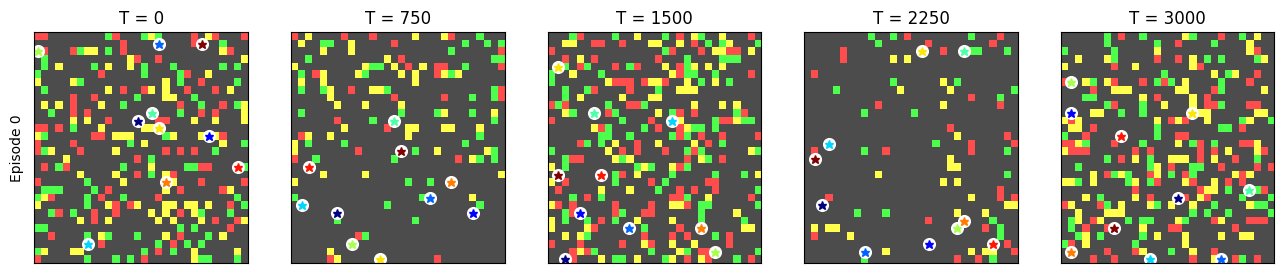

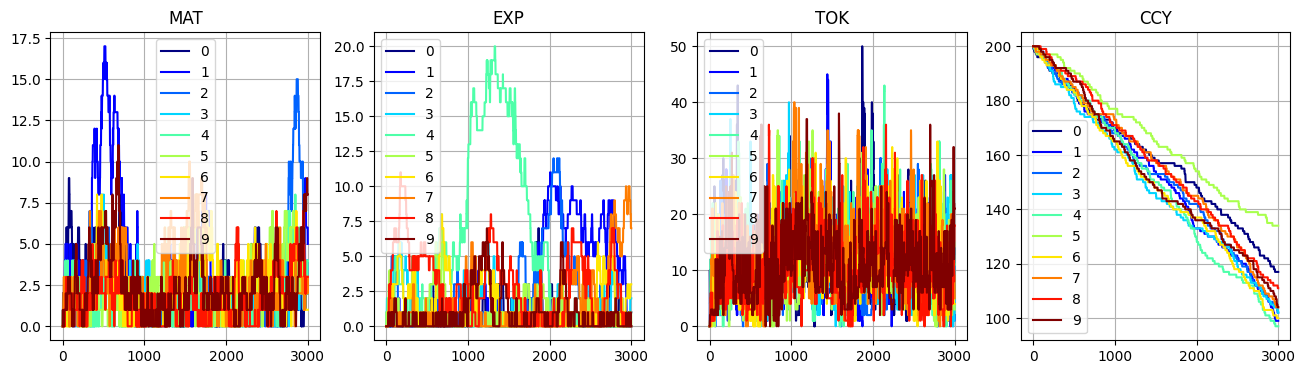

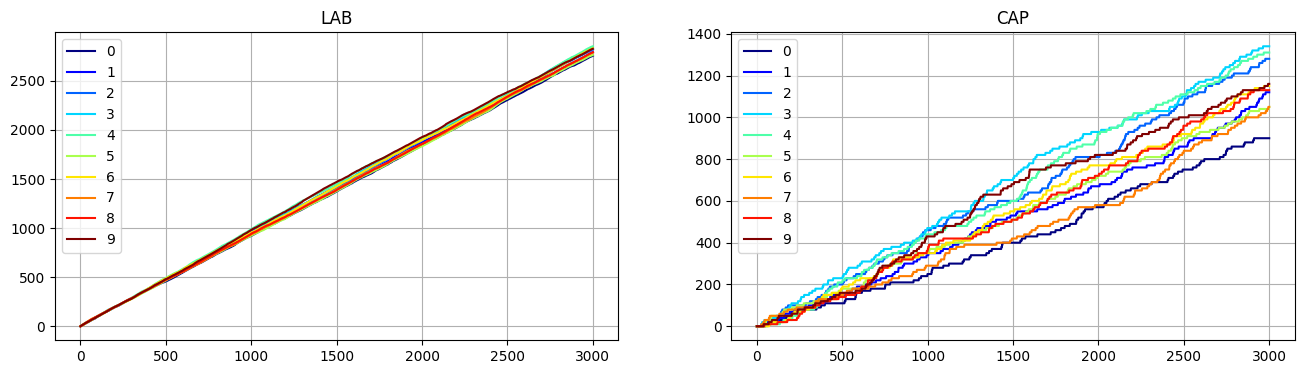

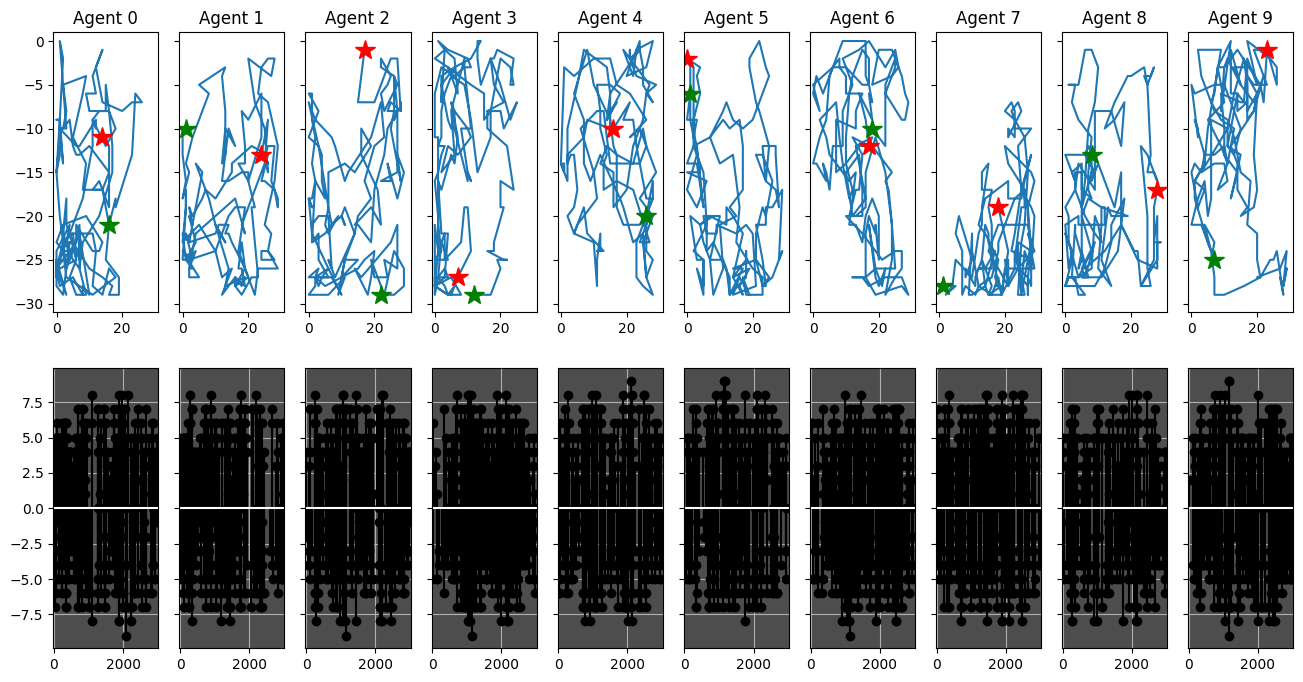

In [5]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, dummy_env, num_dense_logs=1
)
print(dummy_env.env._player_monetary_cost_sensitivities)
print(dummy_env.env._player_nonmonetary_cost_sensitivities)
plotting.breakdown(dense_logs[0])